## Entrenamiento detector de emociones.

In [ ]:
import os
import cv2
import numpy as np
from deepface import DeepFace
from time import time
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
import joblib
import warnings
from tqdm import tqdm
import tensorflow as tf

# Configuración de GPU/CPU y comprobación de disponibilidad de GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.list_physical_devices('GPU')
print("GPUs disponibles:", gpus)
warnings.filterwarnings("ignore")

# --- CONFIGURACIÓN GLOBAL ---
EMBEDDING_MODEL = "VGG-Face"
K_FOLDS = 5
DETECTOR_BACKEND = 'retinaface'

def LoadDataset_Expression(folder, ext):
    """Carga un dataset y extrae características como vectores del mismo retornandolas junto a sus etiquetas."""
    
    X = []
    Y_names = []

    all_files = []
    for class_name in os.listdir(folder):
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            all_files.extend([os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.endswith(ext)])

    total_images = len(all_files)
    print(f"Total de archivos encontrados: {total_images}")
    print(f"Extrayendo embeddings con {EMBEDDING_MODEL}...")

    with tqdm(total=total_images, desc="Extrayendo embeddings") as pbar:
        for img_path in all_files:
            try:
                
                # Extraer embeddings: DeepFace se encarga de la detección y alineación
                embedding_objs = DeepFace.represent(
                    img_path,
                    model_name=EMBEDDING_MODEL,
                    detector_backend=DETECTOR_BACKEND,
                    enforce_detection=False
                )

                # --- Adaptación para el formato de salida de DeepFace ---
                img_embedding = None
                
                if embedding_objs and len(embedding_objs) > 0:
                    
                    # Diferentes versiones de Deepface devuelven los embeddings en estructuras de datos diferentes
                    if isinstance(embedding_objs, list) and isinstance(embedding_objs[0], dict) and "embedding" in embedding_objs[0]:
                        img_embedding = embedding_objs[0]["embedding"]
                    elif isinstance(embedding_objs, list) and all(isinstance(x, (float, np.float32, np.float64)) for x in embedding_objs):
                        img_embedding = embedding_objs
                    
                    # Si hay embedding válido lo añadimos
                    if img_embedding and len(img_embedding) > 0:
                        X.append(img_embedding)
                        Y_names.append(os.path.basename(os.path.dirname(img_path)))

            except Exception as e:
                pass
            pbar.update(1)

    # Convertir a arrays y codificar etiquetas
    X = np.array(X, dtype='float32')
    Y_names = np.array(Y_names)

    if len(X) == 0:
        print("ERROR: No se generaron embeddings válidos.")
        return np.array([]), np.array([]), 0, 0, 0, [], None

    label_encoder = LabelEncoder()
    Y = label_encoder.fit_transform(Y_names)

    n_samples, n_features = X.shape
    n_classes = len(label_encoder.classes_)
    class_names = label_encoder.classes_

    print(f"\nDataset info:\n# samples: {n_samples}\n# features: {n_features}\n# classes: {n_classes}")
    print(f"Classes: {class_names}")

    return X, Y, n_samples, n_features, n_classes, class_names, label_encoder

def train_and_evaluate_model(X, Y, n_classes, class_names, k_folds):
    """Entrena un modelo usando K-Fold Cross-Validation para la evaluación y Support Vector Machines para la clasificación."""

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=4)
    precs_svm, recs_svm = [], []
    final_model = None

    fold = 1
    for train_index, test_index in skf.split(X, Y):
        print(f"\n*** Fold {fold} ***")
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        # Normalización
        scaler = MinMaxScaler()
        X_train_norm = scaler.fit_transform(X_train)
        X_test_norm = scaler.transform(X_test)

        # GridSearch SVM
        print("Entrenando SVM (GridSearchCV)...")
        t0 = time()
        params = {'C': [1e3, 5e3, 1e4], 'gamma': [0.0001, 0.001, 0.01]}
        clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', probability=True),
                           params, cv=3, n_jobs=-1)
        clf.fit(X_train_norm, y_train)
        print(f"Done in {(time() - t0):.2f}s")

        # Predicción y métricas
        y_pred = clf.predict(X_test_norm)
        precs_svm.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        recs_svm.append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

        fold += 1

    # Estadísticas generales.
    print("\n******** K-FOLD SUMMARY ********")
    print(f"Mean Precision: {np.mean(precs_svm):.3f}, Mean Recall: {np.mean(recs_svm):.3f}")

    print("\n--- Entrenando Modelo Final ---")
    final_scaler = MinMaxScaler().fit(X)
    X_norm_final = final_scaler.transform(X)
    final_model = clf.best_estimator_.fit(X_norm_final, Y)

    return final_model, final_scaler


if __name__ == "__main__":
    
    dataset_folder = "./MATERIAL PRACTICA/DATASET/EmotionsDataSet/"

    X, Y, n_samples, n_features, n_classes, class_names, label_encoder = LoadDataset_Expression(dataset_folder, ".png") 
    print("============== Características extraidas============== ")

    if n_samples > 0:
        final_model, final_scaler = train_and_evaluate_model(X, Y, n_classes, class_names, K_FOLDS)
        # Guardar modelos
        joblib.dump(final_model, "svm_expression_model.pkl")
        joblib.dump(final_scaler, "scaler_expression.pkl")
        joblib.dump(label_encoder, "label_encoder_expression.pkl")
        print("\nModelos guardados correctamente.")
    else:
        print("No se generaron embeddings, revisa tu dataset y rutas.")

Done in 1211.81s
              precision    recall  f1-score   support

       angry       0.44      0.51      0.47       152
   disgusted       0.19      0.24      0.21        21
     fearful       0.31      0.27      0.29       169
       happy       0.81      0.70      0.75       265
     neutral       0.54      0.50      0.52       178
         sad       0.44      0.53      0.48       192
   surprised       0.66      0.66      0.66       139

    accuracy                           0.53      1116
   macro avg       0.48      0.49      0.48      1116
weighted avg       0.55      0.53      0.54      1116


*** Fold 2 ***
Entrenando SVM (GridSearchCV)...
Done in 1668.67s
              precision    recall  f1-score   support

       angry       0.39      0.47      0.42       152
   disgusted       0.60      0.29      0.39        21
     fearful       0.29      0.25      0.27       169
       happy       0.74      0.69      0.71       265
     neutral       0.48      0.49      0.49      

## Primer filtro, añade un emoji según la emoción detectada.

In [1]:
import cv2
import numpy as np
from deepface import DeepFace
import joblib
import sys
from PIL import Image


# Cargar modelo
try:
    final_svm_model = joblib.load('svm_expression_model.pkl')
    final_scaler = joblib.load('scaler_expression.pkl')
    label_encoder = joblib.load('label_encoder_expression.pkl')
    class_names = label_encoder.classes_
except FileNotFoundError as e:
    print(f"Error: No se encontraron los archivos del modelo: {e}")
    sys.exit(1)

# Cargar emojis 
try:
    emojis = dict()
    emojis["happy"] = cv2.imread('images/emojis/happy-emoji.png', cv2.IMREAD_UNCHANGED)
    emojis["disgusted"] = cv2.imread('images/emojis/disgusted-emoji.png', cv2.IMREAD_UNCHANGED)
    emojis["angry"]  = cv2.imread('images/emojis/angry-emoji.png', cv2.IMREAD_UNCHANGED)
    emojis["neutral"]  = cv2.imread('images/emojis/neutral-emoji.png', cv2.IMREAD_UNCHANGED)
    emojis["fearful"] = cv2.imread('images/emojis/fearful-emoji.png', cv2.IMREAD_UNCHANGED)
    emojis["sad"] = cv2.imread('images/emojis/sad-emoji.png', cv2.IMREAD_UNCHANGED)
    emojis["surprised"] = cv2.imread('images/emojis/surprised-emoji.png', cv2.IMREAD_UNCHANGED)

    
except:
    happy_emoji = None

# Configuración
EMBEDDING_MODEL = "VGG-Face"
DETECTOR_BACKEND = "retinaface"

# Webcam
cap = cv2.VideoCapture(0)
gif_frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    detected_expression = "Buscando rostro..."
    
    try:
        faces = DeepFace.extract_faces(frame, detector_backend=DETECTOR_BACKEND)
        
        for face in faces:
            x, y, w, h = face['facial_area']['x'], face['facial_area']['y'], \
                         face['facial_area']['w'], face['facial_area']['h']
            
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            face_img = face['face']
            if face_img.max() <= 1.0:
                face_img = (face_img * 255).astype(np.uint8)
            
            embedding_objs = DeepFace.represent(
                face_img,
                model_name=EMBEDDING_MODEL,
                enforce_detection=False
            )
            
            if embedding_objs:
                embedding = np.array(embedding_objs[0]["embedding"])
                
                # TRUNCAR si tiene más features de las esperadas
                expected_features = final_svm_model.n_features_in_
                if len(embedding) > expected_features:
                    embedding = embedding[:expected_features]
                X_test = embedding.reshape(1, -1)
                X_test = final_scaler.transform(X_test)
                
                predicted_class_num = final_svm_model.predict(X_test)
                predicted_expression = label_encoder.inverse_transform(predicted_class_num)[0]
                detected_expression = predicted_expression
                cv2.putText(frame, detected_expression, (x, y - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                
                if emojis[detected_expression] is not None:
                    # Redimensionar el emoji al tamaño del bounding box (w, h)
                    emoji_resized = cv2.resize(emojis[detected_expression], (w, h))

                    # Nos quedamos con la region de interés
                    y1, y2 = max(0, y), min(frame.shape[0], y + h)
                    x1, x2 = max(0, x), min(frame.shape[1], x + w)

                    # Si las dimensiones redimensionadas no coinciden con el recorte, ajustamos el recorte
                    h_roi = y2 - y1
                    w_roi = x2 - x1
                    
                    if h_roi > 0 and w_roi > 0:
                        b, g, r, alpha = cv2.split(emoji_resized)
                        alpha_norm = alpha / 255.0 
                        alpha_inv = 1.0 - alpha_norm
                        emoji_bgr = cv2.merge([b, g, r]).astype(float)
                        roi = frame[y1:y2, x1:x2].astype(float)
                        background = cv2.multiply(roi, cv2.merge([alpha_inv, alpha_inv, alpha_inv]))
                        foreground = cv2.multiply(emoji_bgr, cv2.merge([alpha_norm, alpha_norm, alpha_norm]))
                        blended = cv2.add(background, foreground)    
                        frame[y1:y2, x1:x2] = blended.astype(np.uint8)
        
    except Exception as e:
        print(f"Error: {e}")
    
    cv2.putText(frame, f"Expresion: {detected_expression}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    cv2.imshow("Filtro de emociones con emoticonos", frame)
    gif_frames.append(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

""" 
DESCOMENTAR SI SE QUIERE GUARDAR UN GIF
if len(gif_frames) > 0:
    gif_frames[0].save(
        "emotions.gif",
        save_all=True,
        append_images=gif_frames[1:],
        duration=100,  
        loop=0
    )
    print("GIF guardado como output.gif")
"""

' \nDESCOMENTAR SI SE QUIERE GUARDAR UN GIF\nif len(gif_frames) > 0:\n    gif_frames[0].save(\n        "emotions.gif",\n        save_all=True,\n        append_images=gif_frames[1:],\n        duration=100,  \n        loop=0\n    )\n    print("GIF guardado como output.gif")\n'

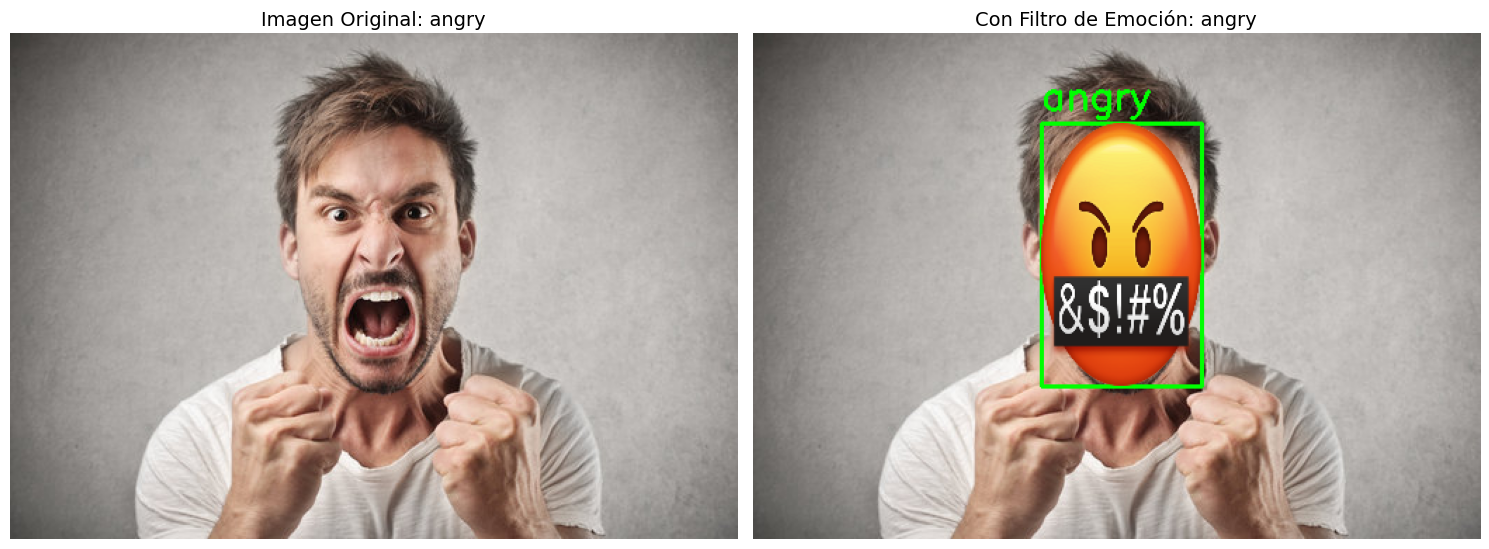

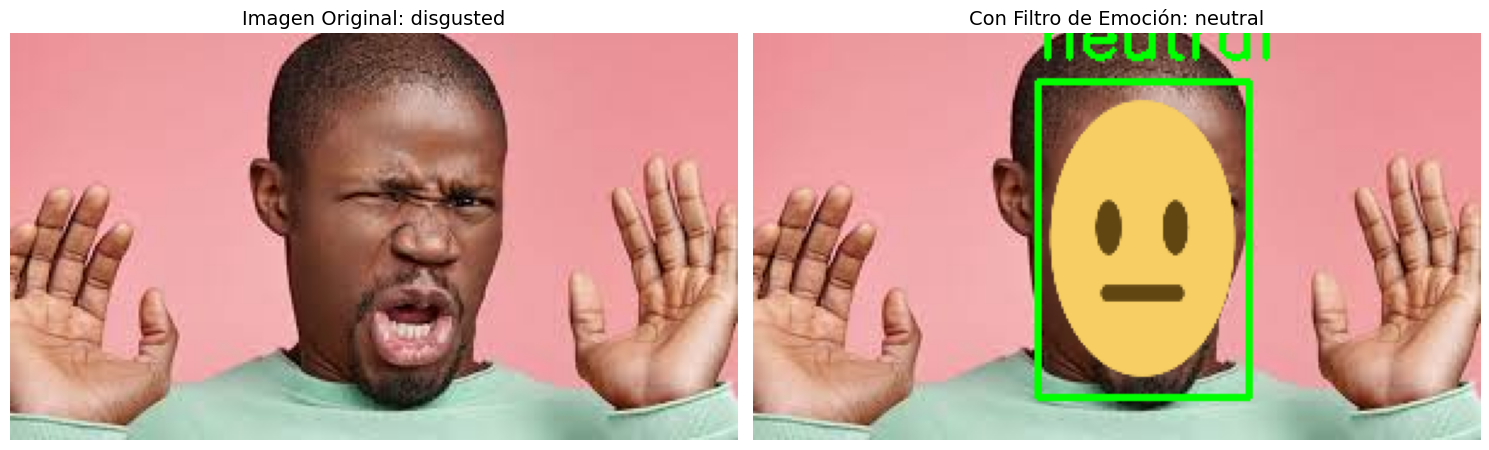

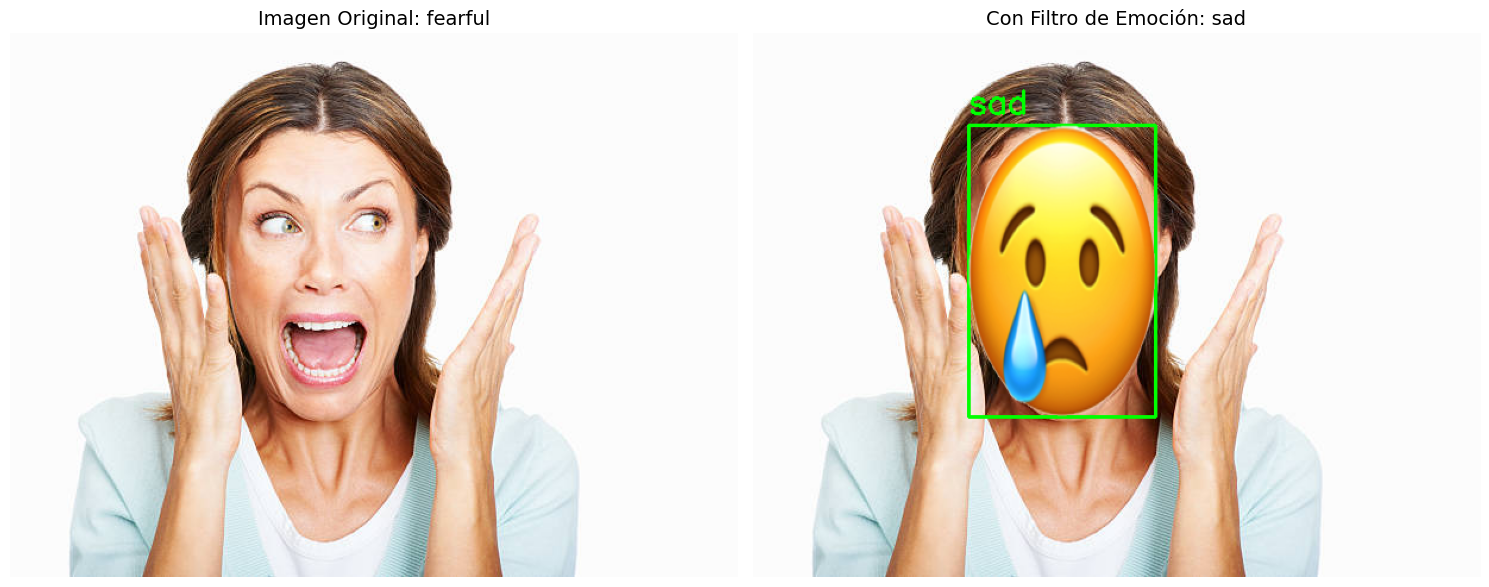

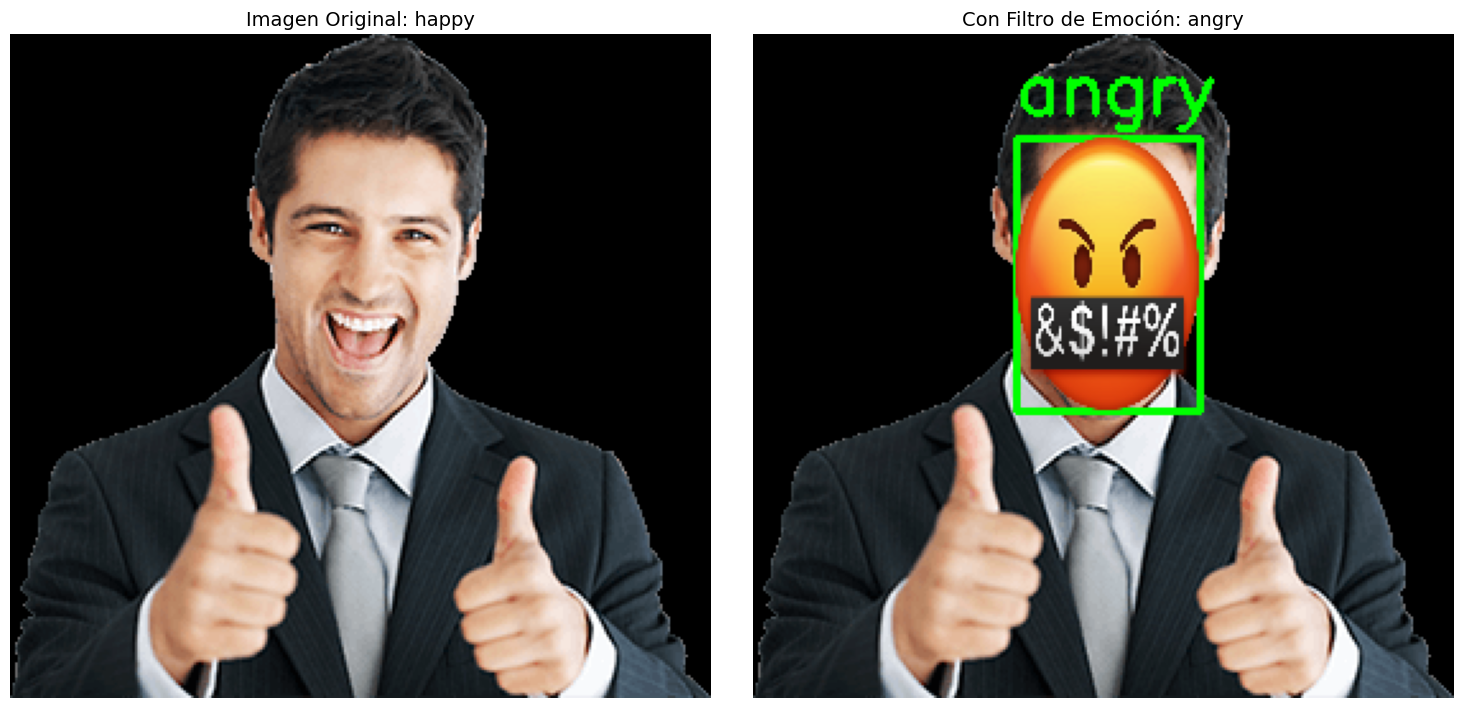

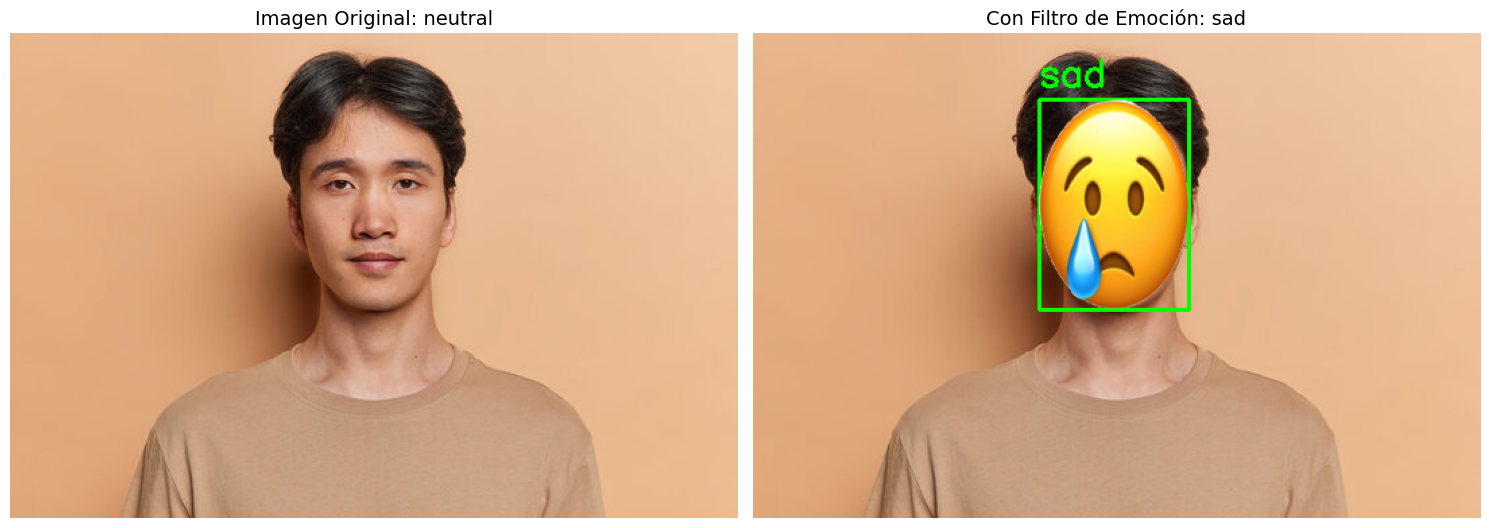

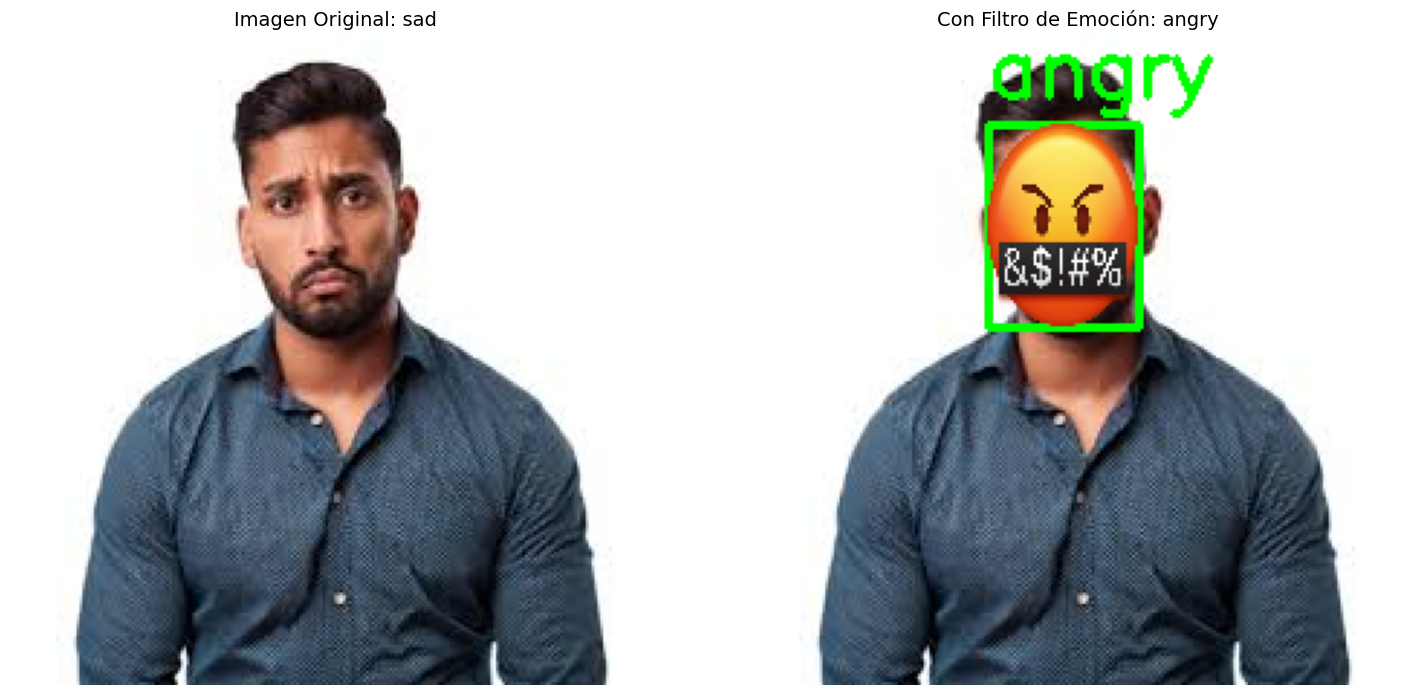

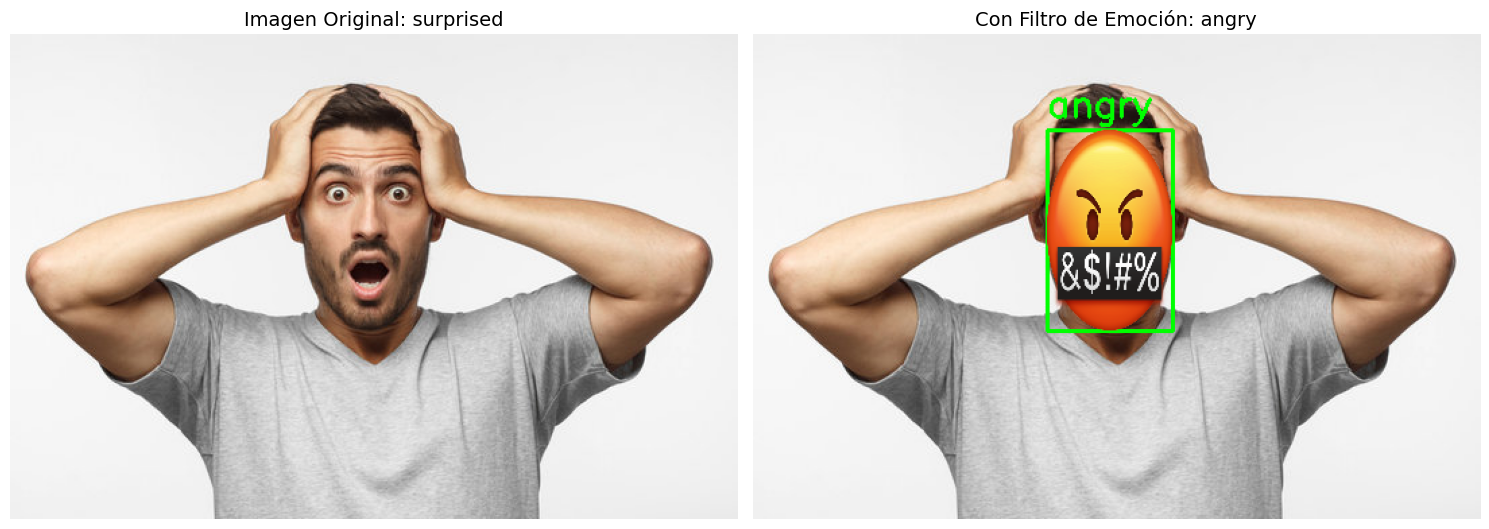

In [1]:
import cv2
import numpy as np
from deepface import DeepFace
import joblib
import sys
from PIL import Image
import matplotlib.pyplot as plt
import os


def apply_emotion_filter(image_path):
    """
    Aplica el filtro de emociones a una imagen y muestra comparativa original vs procesada.
    Devuelve la imagen resultado y la comparativa.
    """
    # Cargar modelo
    try:
        final_svm_model = joblib.load('svm_expression_model.pkl')
        final_scaler = joblib.load('scaler_expression.pkl')
        label_encoder = joblib.load('label_encoder_expression.pkl')
        class_names = label_encoder.classes_
    except FileNotFoundError as e:
        print(f"Error: No se encontraron los archivos del modelo: {e}")
        sys.exit(1)

    # Cargar emojis (con transparencia)
    try:
        emojis = dict()
        emojis["happy"] = cv2.imread('images/emojis/happy-emoji.png', cv2.IMREAD_UNCHANGED)
        emojis["disgusted"] = cv2.imread('images/emojis/disgusted-emoji.png', cv2.IMREAD_UNCHANGED)
        emojis["angry"] = cv2.imread('images/emojis/angry-emoji.png', cv2.IMREAD_UNCHANGED)
        emojis["neutral"] = cv2.imread('images/emojis/neutral-emoji.png', cv2.IMREAD_UNCHANGED)
        emojis["fearful"] = cv2.imread('images/emojis/fearful-emoji.png', cv2.IMREAD_UNCHANGED)
        emojis["sad"] = cv2.imread('images/emojis/sad-emoji.png', cv2.IMREAD_UNCHANGED)
        emojis["surprised"] = cv2.imread('images/emojis/surprised-emoji.png', cv2.IMREAD_UNCHANGED)
    except Exception as e:
        print(f"Advertencia: Error cargando emojis: {e}")
        emojis = {key: None for key in ["happy", "disgusted", "angry", "neutral", "fearful", "sad", "surprised"]}

    # Configuración
    EMBEDDING_MODEL = "VGG-Face"
    DETECTOR_BACKEND = "retinaface"

    # Cargar imagen
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Error: No se pudo cargar la imagen {image_path}")
        return
    
    # Guardar copia original
    original = frame.copy()
    
    detected_expression = "No se detectó rostro"
    
    try:
        faces = DeepFace.extract_faces(frame, detector_backend=DETECTOR_BACKEND)
        
        for face in faces:
            x, y, w, h = face['facial_area']['x'], face['facial_area']['y'], \
                         face['facial_area']['w'], face['facial_area']['h']
            
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            face_img = face['face']
            if face_img.max() <= 1.0:
                face_img = (face_img * 255).astype(np.uint8)
            
            embedding_objs = DeepFace.represent(
                face_img,
                model_name=EMBEDDING_MODEL,
                enforce_detection=False
            )
            
            if embedding_objs:
                embedding = np.array(embedding_objs[0]["embedding"])
                
                # TRUNCAR si tiene más features de las esperadas
                expected_features = final_svm_model.n_features_in_
                if len(embedding) > expected_features:
                    embedding = embedding[:expected_features]
                
                X_test = embedding.reshape(1, -1)
                X_test = final_scaler.transform(X_test)
                
                # Predicción
                predicted_class_num = final_svm_model.predict(X_test)
                predicted_expression = label_encoder.inverse_transform(predicted_class_num)[0]
                detected_expression = predicted_expression
                
                cv2.putText(frame, detected_expression, (x, y - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                
                if emojis.get(detected_expression) is not None:
                    # Redimensionar el emoji al tamaño del bounding box (w, h)
                    emoji_resized = cv2.resize(emojis[detected_expression], (w, h))

                    # roi
                    y1, y2 = max(0, y), min(frame.shape[0], y + h)
                    x1, x2 = max(0, x), min(frame.shape[1], x + w)

                    # Si las dimensiones redimensionadas no coinciden con el recorte, ajustamos el recorte
                    h_roi = y2 - y1
                    w_roi = x2 - x1
                    
                    if h_roi > 0 and w_roi > 0:
                        emoji_resized = cv2.resize(emojis[detected_expression], (w_roi, h_roi))
                        b, g, r, alpha = cv2.split(emoji_resized)
                        alpha_norm = alpha / 255.0 
                        alpha_inv = 1.0 - alpha_norm
                        emoji_bgr = cv2.merge([b, g, r]).astype(float)
                        roi = frame[y1:y2, x1:x2].astype(float)
                        background = cv2.multiply(roi, cv2.merge([alpha_inv, alpha_inv, alpha_inv]))
                        foreground = cv2.multiply(emoji_bgr, cv2.merge([alpha_norm, alpha_norm, alpha_norm]))
                        blended = cv2.add(background, foreground)    
                        frame[y1:y2, x1:x2] = blended.astype(np.uint8)
        
    except Exception as e:
        print(f"Error procesando rostros: {e}")
    

    filename = os.path.basename(image_path)  
    emotion = filename.rsplit(".", 1)[0].split("-")[0] # Extraer nombre de la emoción del nombre de la imagen

    # Mostrar comparativa
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'Imagen Original: {emotion}', fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Con Filtro de Emoción: {detected_expression}', fontsize=14)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    comparativa = np.array(fig.canvas.renderer.buffer_rgba()) # Extraemos la imagen comparativa para devolverla

    return frame, comparativa



CARPETA = "images/emoji-test/"
CARPETA_SALIDA = "images/results/emoji"
os.makedirs(CARPETA_SALIDA, exist_ok=True)
for archivo in os.listdir(CARPETA):
    if archivo.lower().endswith((".jpg", ".jpeg", ".png")):
        ruta = os.path.join(CARPETA, archivo)
        processed_image, comparativa = apply_emotion_filter(ruta)
        img_rgb = cv2.cvtColor(comparativa, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(comparativa[:, :, :3])
        pil_img.save(f"{CARPETA_SALIDA}/{archivo}")


## Segundo filtro, añade accesorios según la edad.

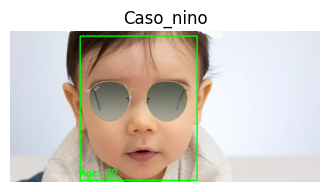

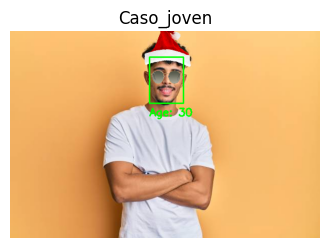

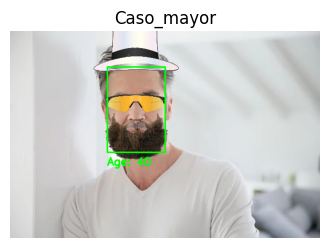

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  
from deepface import DeepFace
from PIL import Image


def load_asset(path, name):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"No se pudo cargar '{name}' ({path})")
    return img

kid_hat_img        = load_asset('images/second-filter-images/kidhat.png',        "kidhat.png")
young_glasses_img  = load_asset('images/second-filter-images/young_glasses.png', "young_glasses.png")
young_hat_img      = load_asset('images/second-filter-images/young_Hat.png',     "young_Hat.png")
older_glasses_img  = load_asset('images/second-filter-images/older_glasses.png', "older_glasses.png")
beard_img          = load_asset('images/second-filter-images/mustache.png',      "mustache.png (barba)")
old_hat_img        = load_asset('images/second-filter-images/old_Hat.png',       "old_Hat.png")


def overlay_png(frame, png_rgba, x, y, w, h):
    """
    Superpone png_rgba (RGBA) sobre frame (BGR)
    en la posición (x, y) con tamaño (w, h).
    Recorta correctamente el overlay cuando se sale
    por los bordes del frame.
    """
    if png_rgba is None or w <= 0 or h <= 0:
        return frame

    # Redimensionar overlay al tamaño objetivo
    overlay = cv2.resize(png_rgba, (w, h))
    H_o, W_o = overlay.shape[:2]
    H_f, W_f = frame.shape[:2]

    # Coordenadas de la región de interés en el frame
    x1_f = max(0, x)
    y1_f = max(0, y)
    x2_f = min(W_f, x + W_o)
    y2_f = min(H_f, y + H_o)

    # Si no hay intersección, salir
    if x1_f >= x2_f or y1_f >= y2_f:
        return frame

    # Dimensiones reales de la región de interés
    roi_w = x2_f - x1_f
    roi_h = y2_f - y1_f

    # Coordenadas correspondientes en el overlay
    x1_o = x1_f - x        
    y1_o = y1_f - y        
    x2_o = x1_o + roi_w
    y2_o = y1_o + roi_h

    overlay_roi = overlay[y1_o:y2_o, x1_o:x2_o]

    if overlay_roi.shape[2] < 4:
        bgr = overlay_roi
        alpha = np.ones((overlay_roi.shape[0], overlay_roi.shape[1]), dtype=np.float32)
    else:
        b, g, r, a = cv2.split(overlay_roi)
        bgr = cv2.merge([b, g, r])
        alpha = a.astype(float) / 255.0

    alpha_inv = 1.0 - alpha

    roi = frame[y1_f:y2_f, x1_f:x2_f].astype(float)
    bgr = bgr.astype(float)

    alpha_3  = cv2.merge([alpha, alpha, alpha])
    alpha_i3 = cv2.merge([alpha_inv, alpha_inv, alpha_inv])

    background = cv2.multiply(roi, alpha_i3)
    foreground = cv2.multiply(bgr, alpha_3)

    blended = cv2.add(background, foreground)
    frame[y1_f:y2_f, x1_f:x2_f] = blended.astype(np.uint8)

    return frame

#  configuracion deepface
detector_backend_list = ["opencv", "retinaface", "ssd"]
DETECTOR_BACKEND = detector_backend_list[1]


def apply_age_filter(frame):
    """Aplica filtro según edad detectada a un frame"""
    try:
        results = DeepFace.analyze(
            frame,
            actions=['age'],
            detector_backend=DETECTOR_BACKEND,
            enforce_detection=False
        )

        if isinstance(results, dict):
            results = [results]

        for res in results:
            region = res.get('region', {})
            x = region.get('x', 0)
            y = region.get('y', 0)
            w = region.get('w', 0)
            h = region.get('h', 0)

            # Evitar índices negativos y caras degeneradas
            x = max(0, x)
            y = max(0, y)
            if w <= 0 or h <= 0:
                continue

            age = int(res.get('age', 0))

            if age < 12:
                if kid_hat_img is not None:
                    hat_w = int(w * 1.6)
                    hat_h = int(h * 1.0)
                    hat_x = x - int(0.3 * w)
                    hat_y = y - int(0.7 * hat_h)
                    frame = overlay_png(frame, kid_hat_img, hat_x, hat_y, hat_w, hat_h)

            elif age <= 30:
                if young_glasses_img is not None:
                    g_w = int(w * 1.4)
                    g_h = int(h * 0.6)

                    g_x = x + (w - g_w) // 2
                    g_y = y + int(h * 0.14)   

                    frame = overlay_png(frame, young_glasses_img, g_x, g_y, g_w, g_h)

                if young_hat_img is not None:
                    hat_w = int(w * 1.6)
                    hat_h = int(h * 1.0)
                    hat_x = x - int(0.3 * w)
                    hat_y = y - hat_h + 25
                    frame = overlay_png(frame, young_hat_img, hat_x, hat_y, hat_w, hat_h)

            else:
                if older_glasses_img is not None:
                    g_w = int(w * 1.1)
                    g_h = int(h * 0.35)
                    g_x = x + (w - g_w) // 2
                    g_y = y + int(h * 0.26)
                    frame = overlay_png(frame, older_glasses_img, g_x, g_y, g_w, g_h)

                if beard_img is not None:
                    b_w = int(w * 1.1)
                    b_h = int(h * 0.55)
                    b_x = x - int(0.05 * w)
                    b_y = y + int(h * 0.55)
                    frame = overlay_png(frame, beard_img, b_x, b_y, b_w, b_h)

                if old_hat_img is not None:
                    hat_w = int(w * 1.6)
                    hat_h = int(h * 1.0)
                    hat_x = x - int(0.3 * w)
                    hat_y = y - hat_h + 25
                    frame = overlay_png(frame, old_hat_img, hat_x, hat_y, hat_w, hat_h)


            #  Dibuja la caja alrededor de la cara          
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            text_y = y + h + 25
            if text_y > frame.shape[0] - 10:
                text_y = y + h - 10
            # muestra la edad detectada
            cv2.putText(frame, f"Age: {age}", (x, text_y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    except Exception as e:
        print("Error en DeepFace.analyze:", e)

    return frame

#  se obtiene el video de la webcam y se guarda en un archivo
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("No se pudo abrir la cámara")
    exit()

frame_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
if fps is None or fps == 0:
    fps = 25.0

gif_frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = apply_age_filter(frame)

    cv2.imshow("Filtro por edad", frame)
    gif_frames.append(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

    if cv2.waitKey(1) & 0xFF == 27:  # ESC
        break

cap.release()
cv2.destroyAllWindows()

if len(gif_frames) > 0:
    gif_frames[0].save(
        "filtro_edad_output.gif",
        save_all=True,
        append_images=gif_frames[1:],
        duration=100,
        loop=0
    )
 
test_images = [
    ("Caso_nino",  "images/second-filter-images/test_kid.png",   "images/results/output_kid_filtered.jpg"),
    ("Caso_joven", "images/second-filter-images/test_young.png", "images/results/output_young_filtered.jpg"),
    ("Caso_mayor", "images/second-filter-images/test_old.jpg",   "images/results/output_old_filtered.jpg"),
]

for title, input_path, output_path in test_images:
    img = cv2.imread(input_path)
    if img is None:
        print(f"No se pudo cargar la imagen de prueba: {input_path}")
        continue

    img_filtered = apply_age_filter(img)
    cv2.imwrite(output_path, img_filtered)

    #Mostramos el resultado del test en el cuaderno
    img_rgb = cv2.cvtColor(img_filtered, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4, 4))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')

plt.show()
